In [1]:
import numpy as np 
import pandas as pd 
import os
import re
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add, Flatten, Lambda, Reshape, BatchNormalization, concatenate, AveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
import matplotlib.pyplot as plt
import scipy
from PIL import Image
import random
import cv2
from tensorflow.keras.metrics import MeanAbsoluteError, MeanSquaredError, RootMeanSquaredError, Mean, binary_crossentropy, binary_accuracy
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time

In [2]:
try:
    import google.colab
    in_colab = True
except ImportError:
    in_colab = False

if in_colab:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        tpu_strategy = tf.distribute.TPUStrategy(tpu)
    except ValueError:
        if 'GPU' in [gpu[-1] for gpu in tf.config.list_physical_devices('GPU')]:
            print('Running on Google Colab GPU')
        else:
            print('Not connected to a TPU or GPU runtime')

else:
    physical_devices = tf.config.list_physical_devices('GPU')
    print(physical_devices)
    try:
        if len(physical_devices):
            for gpu in physical_devices:
                tf.config.experimental.set_memory_growth(gpu, enable = True)
                print(f"Using local GPU: {gpu}")
            sess = tf.compat.v1.Session(config = tf.compat.v1.ConfigProto(log_device_placement = True))
        else:
            print("No local GPU found")
    except:
        print("Error Mounting a GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using local GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6



In [3]:
def plot_history(history, model_name, inception_outputs=None):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    if inception_outputs:
        for out in inception_outputs:
            plt.plot(history.history[f'{out}_loss'], label='Training Loss')
            plt.plot(history.history[f'val_{out}_loss'], label='Validation Loss')
            plt.title(f'Training and Validation Loss {model_name} {out}')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()

In [4]:
def plot_metrics(history, model_name, inception_outputs=None):
    # Plot training and validation accuracy
    if inception_outputs:
        for out in inception_outputs:
            plt.figure(figsize=(12, 10))
            plt.subplot(3, 1, 1)
                
            plt.plot(history.history[f'{out}_accuracy'], label=f'{out} training Accuracy')
            plt.plot(history.history[f'val_{out}_accuracy'], label=f'{out} validation Accuracy')
            plt.title(f'Training and Validation Accuracy {model_name} {out}')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()

            # Plot training and validation MAE
            plt.subplot(3, 1, 2)
            plt.plot(history.history[f'{out}_mae'], label='Training MAE')
            plt.plot(history.history[f'val_{out}_mae'], label='Validation MAE')
            plt.title(f'Training and Validation MAE {model_name} {out}')
            plt.xlabel('Epoch')
            plt.ylabel('MAE')
            plt.legend()

            # Plot training and validation RMSE
            plt.subplot(3, 1, 3)
            plt.plot(history.history[f'{out}_rmse'], label='Training RMSE')
            plt.plot(history.history[f'val_{out}_rmse'], label='Validation RMSE')
            plt.title(f'Training and Validation RMSE {model_name} {out}')
            plt.xlabel('Epoch')
            plt.ylabel('RMSE')
            plt.legend()

            plt.tight_layout()
            plt.show()
    else:
        plt.figure(figsize=(12, 10))
        plt.subplot(3, 1, 1)

        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

        plt.title(f'Training and Validation Accuracy {model_name}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        # Plot training and validation MAE
        plt.subplot(3, 1, 2)
        plt.plot(history.history['mae'], label='Training MAE')
        plt.plot(history.history['val_mae'], label='Validation MAE')
        plt.title(f'Training and Validation MAE {model_name}')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.legend()

        # Plot training and validation RMSE
        plt.subplot(3, 1, 3)
        plt.plot(history.history['rmse'], label='Training RMSE')
        plt.plot(history.history['val_rmse'], label='Validation RMSE')
        plt.title(f'Training and Validation RMSE {model_name}')
        plt.xlabel('Epoch')
        plt.ylabel('RMSE')
        plt.legend()

        plt.tight_layout()
        plt.show()


In [5]:
def plot_predictions(model, generator, num_examples=5, seed=42, size=(12, 4)):
    np.random.seed(seed)

    for _ in range(num_examples):
        x_sample, y_sample = next(generator)

        # Predict
        y_pred = model.predict(x_sample, verbose=False)

        # Plot
        plt.figure(figsize=size)
        plt.subplot(1, 3, 1)
        plt.imshow(x_sample[0], cmap='gray')
        plt.title('Original')

        plt.subplot(1, 3, 2)
        plt.imshow(y_sample[0], cmap='gray')
        plt.title('Expected')

        plt.subplot(1, 3, 3)
        plt.imshow(y_pred[0], cmap='gray')
        plt.title('Reconstructed by Model')

        plt.show()

In [6]:
def plot_predictions_many_outputs(model, generator, num_examples=5, seed=42, size=(16, 4)):
    np.random.seed(seed)

    for _ in range(num_examples):
        x_sample, y_sample = next(generator)

        # Predict
        y_preds = model.predict(x_sample, verbose=False)

        # Plot
        plt.figure(figsize=size)

        # Plot original input
        plt.subplot(1, len(y_preds) + 2, 1)
        plt.imshow(x_sample[0], cmap='gray')
        plt.title('Original')

        # Plot ground truth
        plt.subplot(1, len(y_preds) + 2, 2)
        plt.imshow(y_sample[0], cmap='gray')
        plt.title('Expected')

        # Plot model predictions
        for j, y_pred in enumerate(y_preds):
            plt.subplot(1, len(y_preds) + 2, j + 3)
            plt.imshow(y_pred[0], cmap='gray')
            plt.title(f'Reconstructed by Model (Output {j + 1})')

        plt.show()

In [7]:
EPOCHS = 100
seed = 42

INPUT_SHAPE = (400, 600, 3)
IMAGE_SHAPE = (400, 600)
BATCH_SIZE = 8

In [8]:
base_directory = 'Data'
hires_folder = os.path.join(base_directory, 'high res')
lowres_folder = os.path.join(base_directory, 'low res')

data = pd.read_csv("Data/image_data.csv")
data['low_res'] = data['low_res'].apply(lambda x: os.path.join(lowres_folder, x))
data['high_res'] = data['high_res'].apply(lambda x: os.path.join(hires_folder, x))
#data.head()

# data = filter_df(data, viable_nums=["6"]) # For GAN

train_data, val_test_data = train_test_split(data, test_size=0.2, random_state=seed)
val_data, test_data = train_test_split(val_test_data, test_size=0.5, random_state=seed)

image_datagen = ImageDataGenerator(rescale=1./255)
mask_datagen = ImageDataGenerator(rescale=1./255)

train_hiresimage_generator = image_datagen.flow_from_dataframe(
    train_data,
    x_col='high_res',
    target_size=IMAGE_SHAPE,
    class_mode=None,
    batch_size=BATCH_SIZE,
    seed=seed
)

train_lowresimage_generator = image_datagen.flow_from_dataframe(
    train_data,
    x_col='low_res',
    target_size=IMAGE_SHAPE,
    class_mode=None,
    batch_size=BATCH_SIZE,
    seed=seed
)

val_hiresimage_generator = image_datagen.flow_from_dataframe(
    val_data,
    x_col='high_res',
    target_size=IMAGE_SHAPE,
    class_mode=None,
    batch_size=BATCH_SIZE,
    seed=seed
)

val_lowresimage_generator = image_datagen.flow_from_dataframe(
    val_data,
    x_col='low_res',
    target_size=IMAGE_SHAPE,
    class_mode=None,
    batch_size=BATCH_SIZE,
    seed=seed
)

test_hiresimage_generator = image_datagen.flow_from_dataframe(
    test_data,
    x_col='high_res',
    target_size=IMAGE_SHAPE,
    class_mode=None,
    batch_size=BATCH_SIZE,
    seed=seed
)

test_lowresimage_generator = image_datagen.flow_from_dataframe(
    test_data,
    x_col='low_res',
    target_size=IMAGE_SHAPE,
    class_mode=None,
    batch_size=BATCH_SIZE,
    seed=seed
)

train_generator = zip(train_lowresimage_generator, train_hiresimage_generator)
val_generator = zip(val_lowresimage_generator, val_hiresimage_generator)
test_generator = zip(test_lowresimage_generator, test_hiresimage_generator)

def imageGenerator(generator):
    for (low_res, hi_res) in generator:
        yield (low_res, hi_res)

train_samples = train_hiresimage_generator.samples
val_samples = val_hiresimage_generator.samples

train_img_gen = imageGenerator(train_generator)
val_img_gen = imageGenerator(val_generator)
test_img_gen = imageGenerator(test_generator)

Found 3009 validated image filenames.


Found 3009 validated image filenames.
Found 376 validated image filenames.
Found 376 validated image filenames.
Found 377 validated image filenames.
Found 377 validated image filenames.


In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
tensorboard = TensorBoard(log_dir='logs')

## SSIM Unet

In [10]:
# def ssim_loss(y_true, y_pred):
#     return 1 - tf.image.ssim(y_true, y_pred, max_val=1.0)

In [11]:
# def build_u_net(input_shape=INPUT_SHAPE):
#     # Input layer
#     input_img = Input(shape=input_shape)

#     # Encoder
#     conv1 = Conv2D(16, (3, 3), padding='same', activation='relu')(input_img)
#     conv2 = Conv2D(16, (3, 3), padding='same', activation='relu')(conv1)
#     maxpool1 = MaxPooling2D()(conv2)

#     conv3 = Conv2D(32, (3, 3), padding='same', activation='relu')(maxpool1)
#     conv4 = Conv2D(32, (3, 3), padding='same', activation='relu')(conv3)
#     maxpool2 = MaxPooling2D()(conv4)

#     conv5 = Conv2D(64, (3, 3), padding='same', activation='relu')(maxpool2)
#     conv6 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv5)

#     # Bottleneck
#     bottleneck = Conv2D(64, (3, 3), padding='same', activation='relu')(conv6)
#     maxpool3 = MaxPooling2D(pool_size=(2, 2))(bottleneck)

#     # Decoder
#     upsample1 = UpSampling2D()(maxpool3)
#     concat1 = concatenate([upsample1, conv5], axis=-1)
#     conv7 = Conv2D(64, (3, 3), padding='same', activation='relu')(concat1)
#     conv8 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv7)

#     upsample2 = UpSampling2D()(conv8)
#     concat2 = concatenate([upsample2, conv3], axis=-1)
#     conv9 = Conv2D(32, (3, 3), padding='same', activation='relu')(concat2)
#     conv10 = Conv2D(32, (3, 3), padding='same', activation='relu')(conv9)

#     upsample3 = UpSampling2D()(conv10)
#     concat3 = concatenate([upsample3, conv1], axis=-1)
#     conv11 = Conv2D(16, (3, 3), padding='same', activation='relu')(concat3)
#     conv12 = Conv2D(16, (3, 3), padding='same', activation='relu')(conv11)

#     # Output layer
#     output_img = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(conv12)

#     unet = Model(input_img, output_img)    
#     metrics_list = ['accuracy', ssim_loss, MeanAbsoluteError(name='mae'), RootMeanSquaredError(name='rmse')]
#     unet.compile(optimizer='adam', loss=ssim_loss, metrics=metrics_list)
    
#     return unet

In [12]:
# Unet = build_u_net()

In [13]:
# start_time = time.time()

# history = Unet.fit(
#     train_img_gen,
#     epochs=EPOCHS,
#     batch_size=BATCH_SIZE,
#     steps_per_epoch=train_samples//BATCH_SIZE,
#     validation_data = val_img_gen,
#     validation_steps=val_samples//BATCH_SIZE,
#     callbacks=[early_stopping, reduce_lr_plateau]
# )

# end_time = time.time()
# training_time = end_time - start_time
# model_name = "Unet"
# time_dict = {model_name: training_time}

In [14]:
# Unet.save("models/trained_unet_alt_loss.h5")
# print(f"Model size: {os.stat('models/trained_unet_alt_loss.h5').st_size / 1024} kB")

In [15]:
# plot_history(history, "Unet")

In [16]:
# plot_metrics(history, "Unet")

In [17]:
# plot_predictions(Unet,train_img_gen)

In [18]:
# plot_predictions(Unet, test_img_gen)

## MS-SSIM Unet

In [19]:
# def ms_ssim_loss(y_true, y_pred):
#     return 1 - tf.image.ssim_multiscale(y_true, y_pred, max_val=1.0)

In [20]:
# def build_u_net(input_shape=INPUT_SHAPE):
#     # Input layer
#     input_img = Input(shape=input_shape)

#     # Encoder
#     conv1 = Conv2D(16, (3, 3), padding='same', activation='relu')(input_img)
#     conv2 = Conv2D(16, (3, 3), padding='same', activation='relu')(conv1)
#     maxpool1 = MaxPooling2D()(conv2)

#     conv3 = Conv2D(32, (3, 3), padding='same', activation='relu')(maxpool1)
#     conv4 = Conv2D(32, (3, 3), padding='same', activation='relu')(conv3)
#     maxpool2 = MaxPooling2D()(conv4)

#     conv5 = Conv2D(64, (3, 3), padding='same', activation='relu')(maxpool2)
#     conv6 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv5)

#     # Bottleneck
#     bottleneck = Conv2D(64, (3, 3), padding='same', activation='relu')(conv6)
#     maxpool3 = MaxPooling2D(pool_size=(2, 2))(bottleneck)

#     # Decoder
#     upsample1 = UpSampling2D()(maxpool3)
#     concat1 = concatenate([upsample1, conv5], axis=-1)
#     conv7 = Conv2D(64, (3, 3), padding='same', activation='relu')(concat1)
#     conv8 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv7)

#     upsample2 = UpSampling2D()(conv8)
#     concat2 = concatenate([upsample2, conv3], axis=-1)
#     conv9 = Conv2D(32, (3, 3), padding='same', activation='relu')(concat2)
#     conv10 = Conv2D(32, (3, 3), padding='same', activation='relu')(conv9)

#     upsample3 = UpSampling2D()(conv10)
#     concat3 = concatenate([upsample3, conv1], axis=-1)
#     conv11 = Conv2D(16, (3, 3), padding='same', activation='relu')(concat3)
#     conv12 = Conv2D(16, (3, 3), padding='same', activation='relu')(conv11)

#     # Output layer
#     output_img = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(conv12)

#     unet = Model(input_img, output_img)    
#     metrics_list = ['accuracy', ms_ssim_loss, MeanAbsoluteError(name='mae'), RootMeanSquaredError(name='rmse')]
#     unet.compile(optimizer='adam', loss=ms_ssim_loss, metrics=metrics_list)
    
#     return unet

In [21]:
# Unet = build_u_net()

In [22]:
# start_time = time.time()

# history = Unet.fit(
#     train_img_gen,
#     epochs=EPOCHS,
#     batch_size=BATCH_SIZE,
#     steps_per_epoch=train_samples//BATCH_SIZE,
#     validation_data = val_img_gen,
#     validation_steps=val_samples//BATCH_SIZE,
#     callbacks=[early_stopping, reduce_lr_plateau]
# )

# end_time = time.time()
# training_time = end_time - start_time
# model_name = "Unet"
# time_dict = {model_name: training_time}

Epoch 1/100
376/376 [==============================] - 103s 249ms/step - loss: 0.0807 - accuracy: 0.6861 - ms_ssim_loss: 0.0807 - mae: 0.0815 - rmse: 0.1394 - val_loss: 0.0489 - val_accuracy: 0.8219 - val_ms_ssim_loss: 0.0489 - val_mae: 0.0401 - val_rmse: 0.0644 - lr: 0.0010
Epoch 2/100
376/376 [==============================] - 96s 254ms/step - loss: 0.0425 - accuracy: 0.8016 - ms_ssim_loss: 0.0425 - mae: 0.0362 - rmse: 0.0603 - val_loss: 0.0442 - val_accuracy: 0.7877 - val_ms_ssim_loss: 0.0442 - val_mae: 0.0338 - val_rmse: 0.0595 - lr: 0.0010
Epoch 3/100
376/376 [==============================] - 94s 250ms/step - loss: 0.0400 - accuracy: 0.8199 - ms_ssim_loss: 0.0399 - mae: 0.0328 - rmse: 0.0568 - val_loss: 0.0435 - val_accuracy: 0.7455 - val_ms_ssim_loss: 0.0435 - val_mae: 0.0306 - val_rmse: 0.0572 - lr: 0.0010
Epoch 4/100
376/376 [==============================] - 96s 255ms/step - loss: 0.0391 - accuracy: 0.8239 - ms_ssim_loss: 0.0391 - mae: 0.0319 - rmse: 0.0557 - val_loss: 0.0431

In [23]:
# Unet.save("models/trained_unet_ms_ssim_loss.h5")
# print(f"Model size: {os.stat('models/trained_unet_ms_ssim_loss.h5').st_size / 1024} kB")

Model size: 3257.4765625 kB


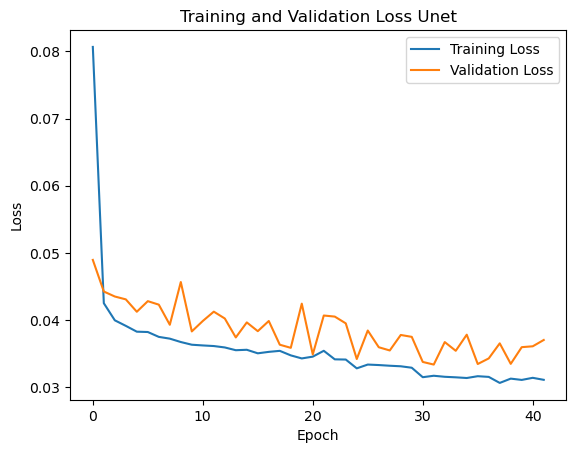

In [24]:
# plot_history(history, "Unet")

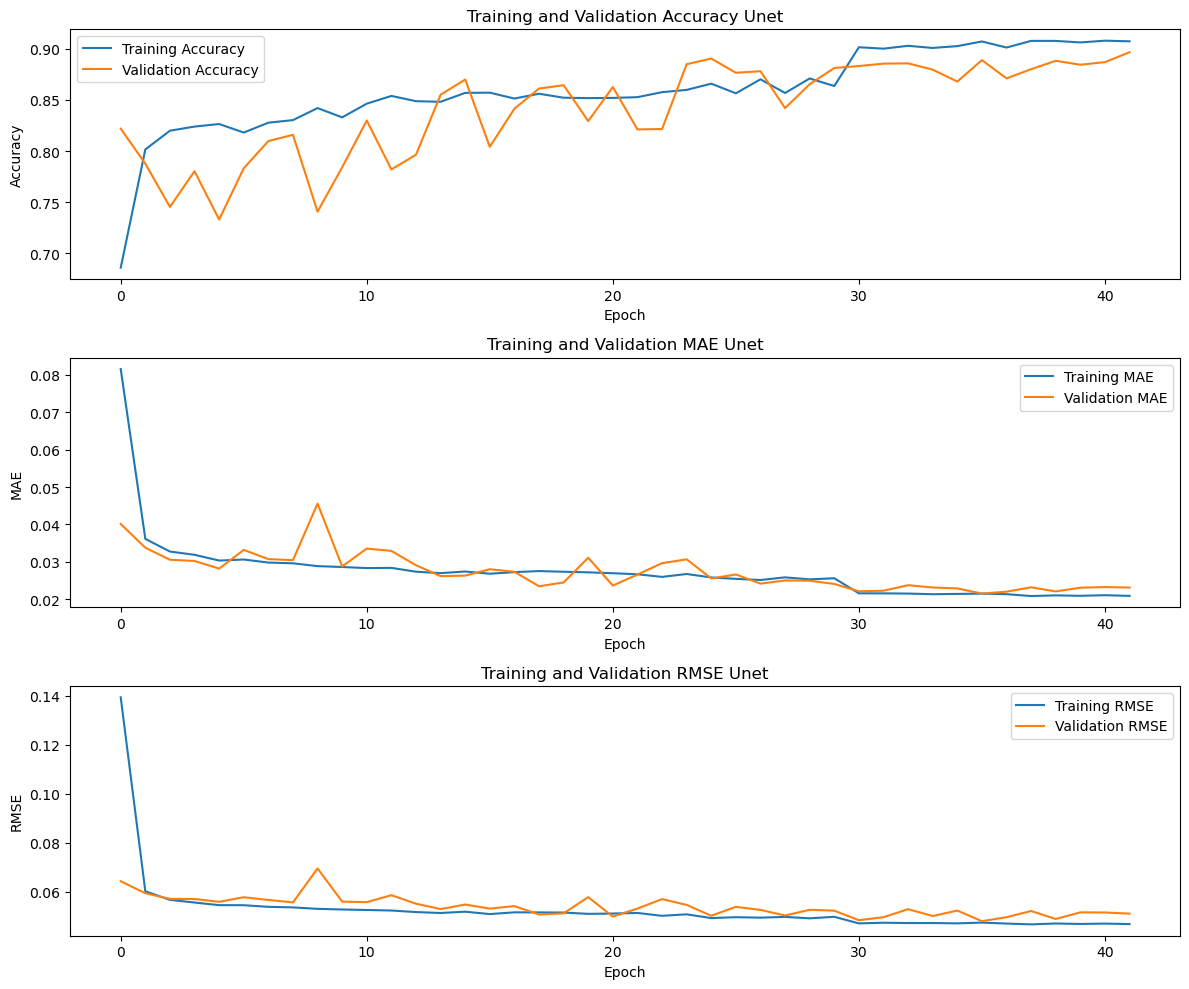

In [25]:
# plot_metrics(history, "Unet")

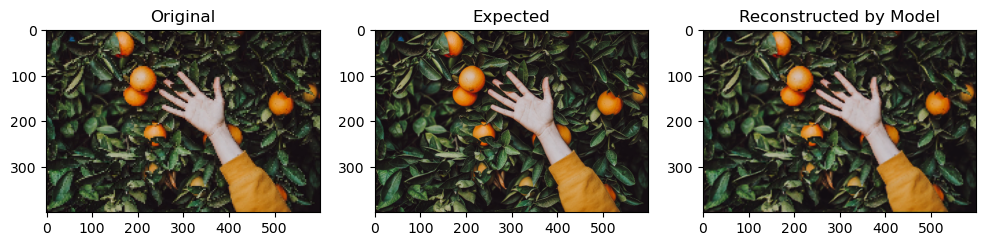

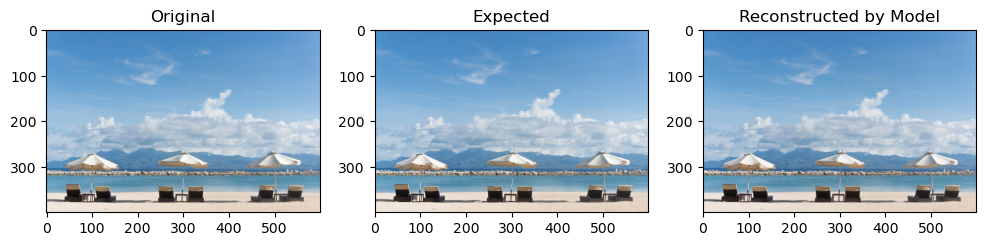

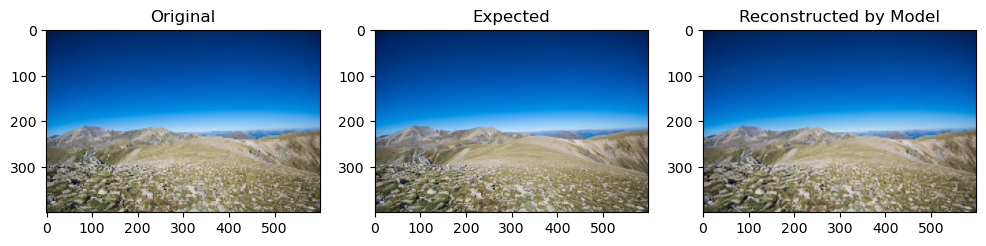

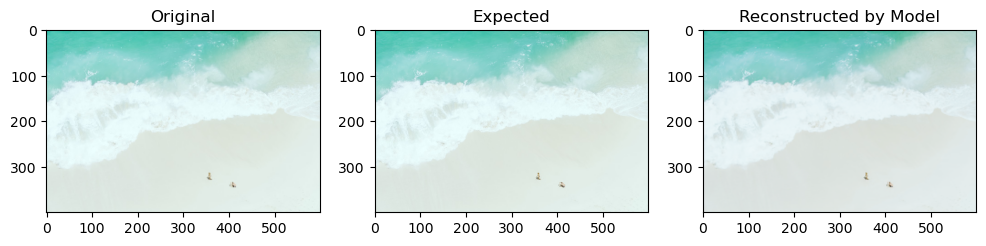

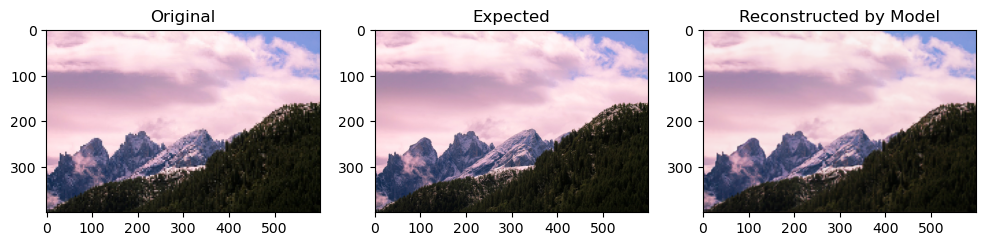

In [26]:
# plot_predictions(Unet,train_img_gen)

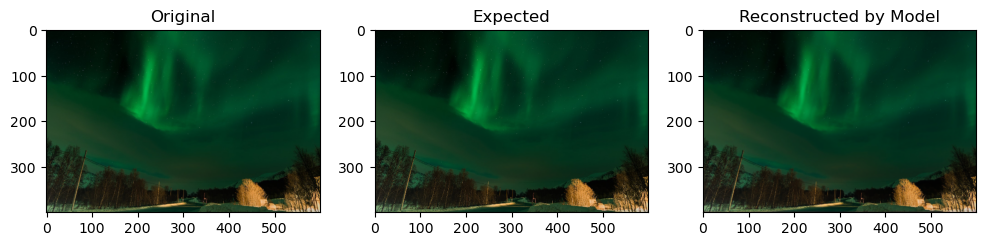

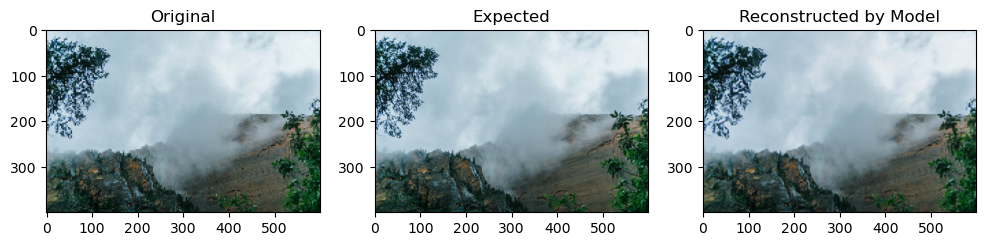

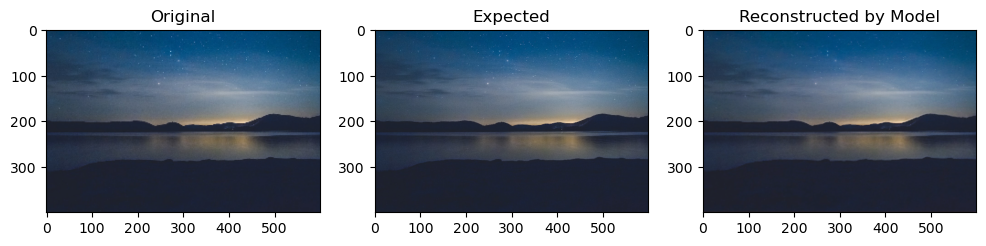

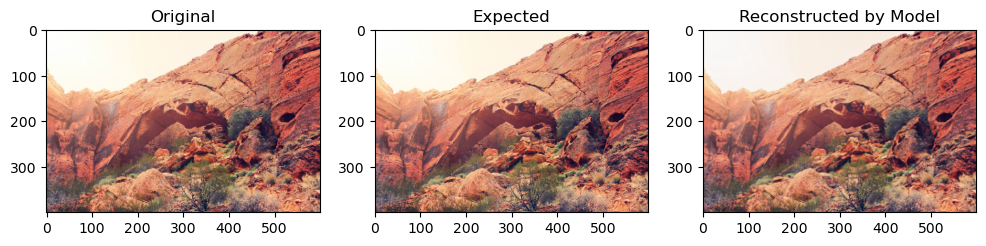

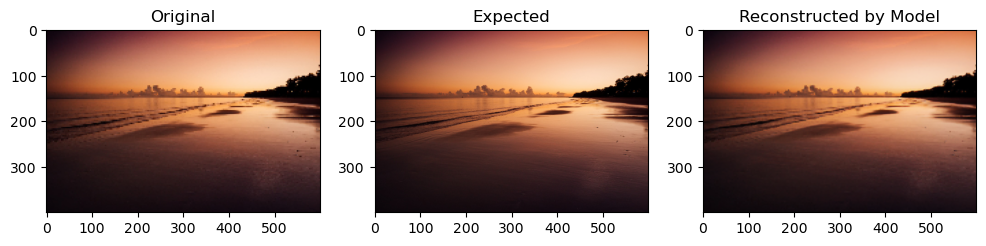

In [27]:
# plot_predictions(Unet, test_img_gen)

## PSNR Unet

In [ ]:
def psnr_loss(y_true, y_pred):
    max_val = 1.0
    return -tf.image.psnr(y_true, y_pred, max_val)

In [ ]:
def build_u_net(input_shape=INPUT_SHAPE):
    # Input layer
    input_img = Input(shape=input_shape)

    # Encoder
    conv1 = Conv2D(16, (3, 3), padding='same', activation='relu')(input_img)
    conv2 = Conv2D(16, (3, 3), padding='same', activation='relu')(conv1)
    maxpool1 = MaxPooling2D()(conv2)

    conv3 = Conv2D(32, (3, 3), padding='same', activation='relu')(maxpool1)
    conv4 = Conv2D(32, (3, 3), padding='same', activation='relu')(conv3)
    maxpool2 = MaxPooling2D()(conv4)

    conv5 = Conv2D(64, (3, 3), padding='same', activation='relu')(maxpool2)
    conv6 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv5)

    # Bottleneck
    bottleneck = Conv2D(64, (3, 3), padding='same', activation='relu')(conv6)
    maxpool3 = MaxPooling2D(pool_size=(2, 2))(bottleneck)

    # Decoder
    upsample1 = UpSampling2D()(maxpool3)
    concat1 = concatenate([upsample1, conv5], axis=-1)
    conv7 = Conv2D(64, (3, 3), padding='same', activation='relu')(concat1)
    conv8 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv7)

    upsample2 = UpSampling2D()(conv8)
    concat2 = concatenate([upsample2, conv3], axis=-1)
    conv9 = Conv2D(32, (3, 3), padding='same', activation='relu')(concat2)
    conv10 = Conv2D(32, (3, 3), padding='same', activation='relu')(conv9)

    upsample3 = UpSampling2D()(conv10)
    concat3 = concatenate([upsample3, conv1], axis=-1)
    conv11 = Conv2D(16, (3, 3), padding='same', activation='relu')(concat3)
    conv12 = Conv2D(16, (3, 3), padding='same', activation='relu')(conv11)

    # Output layer
    output_img = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(conv12)

    unet = Model(input_img, output_img)    
    metrics_list = ['accuracy', psnr_loss, MeanAbsoluteError(name='mae'), RootMeanSquaredError(name='rmse')]
    unet.compile(optimizer='adam', loss=psnr_loss, metrics=metrics_list)
    
    return unet

In [ ]:
Unet = build_u_net()

In [ ]:
start_time = time.time()

history = Unet.fit(
    train_img_gen,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch=train_samples//BATCH_SIZE,
    validation_data = val_img_gen,
    validation_steps=val_samples//BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr_plateau]
)

end_time = time.time()
training_time = end_time - start_time
model_name = "Unet"
time_dict = {model_name: training_time}

In [ ]:
Unet.save("models/trained_unet_psnr_loss.h5")
print(f"Model size: {os.stat('models/trained_unet_psnr_loss.h5').st_size / 1024} kB")

In [ ]:
plot_history(history, "Unet")

In [ ]:
plot_metrics(history, "Unet")

In [ ]:
plot_predictions(Unet,train_img_gen)

In [ ]:
plot_predictions(Unet, test_img_gen)